In [1]:
%%capture
!pip install roboflow ultralytics

# Import the necessary packages

In [2]:
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from random import sample
import pandas as pd
from ultralytics import YOLO
from roboflow import Roboflow

# Preparing a custom dataset for YOLOv8

In [3]:
rf = Roboflow(api_key="secret_key")
project = rf.workspace("licence-plate-dswxt").project("license-plate-detection-lyvyv")
version = project.version(5)
dataset = version.download('yolov8')

loading Roboflow workspace...
loading Roboflow project...
Dependency ultralytics==8.0.196 is required but found version=8.2.75, to fix: `pip install ultralytics==8.0.196`



Extracting Dataset Version Zip to License-Plate-Detection-5 in yolov8:: 100%|██████████| 4805/4805 [00:00<00:00, 8280.42it/s]


In [4]:
working_dir = os.listdir(dataset.location)
print(working_dir)

['train', 'README.roboflow.txt', 'data.yaml', 'test', 'valid']


In [8]:
read_me = os.path.join(dataset.location,'README.roboflow.txt')
with open(read_me) as rf:
    content = rf.read()
print(content)


License Plate Detection - v5 License Plate Detection

This dataset was exported via roboflow.com on August 10, 2024 at 12:11 PM GMT

Roboflow is an end-to-end computer vision platform that helps you
* collaborate with your team on computer vision projects
* collect & organize images
* understand and search unstructured image data
* annotate, and create datasets
* export, train, and deploy computer vision models
* use active learning to improve your dataset over time

For state of the art Computer Vision training notebooks you can use with this dataset,
visit https://github.com/roboflow/notebooks

To find over 100k other datasets and pre-trained models, visit https://universe.roboflow.com

The dataset includes 2397 images.
Workers are annotated in YOLOv8 format.

The following pre-processing was applied to each image:
* Auto-orientation of pixel data (with EXIF-orientation stripping)
* Resize to 720x360 (Stretch)

The following augmentation was applied to create 3 versions of each sour

In [9]:
train_dir = os.path.join(dataset.location,'train')
print(os.listdir(train_dir))

train_images= os.path.join(train_dir,'images')
train_labels= os.path.join(train_dir,'labels')
print(train_images)
print(train_labels)

['labels', 'images']
/kaggle/working/License-Plate-Detection-5/train/images
/kaggle/working/License-Plate-Detection-5/train/labels


In [11]:
label_path = os.path.join(train_labels, os.listdir(train_labels)[0])
print(label_path)

with open(label_path) as rf:
    content = rf.read()  # Corrected method name
print(content)

/kaggle/working/License-Plate-Detection-5/train/labels/OD-22X-9011_jpg.rf.a5428c6b96dadc1567f31f2fe3c93ac4.txt
0 0.15208333333333332 0.7083333333333334 0.12013888888888889 0.24305555555555555


In [12]:
def display_image(image, title="Image"):
    """Display the image using matplotlib."""
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 7), dpi=123)
    plt.imshow(rgb_image)
    plt.axis('off')
    plt.title(title)
    plt.show()

/kaggle/working/License-Plate-Detection-5/train/images/OD-09K-7721_jpg.rf.9e9e38bae559eddebfab76ae5e5f61e1.jpg


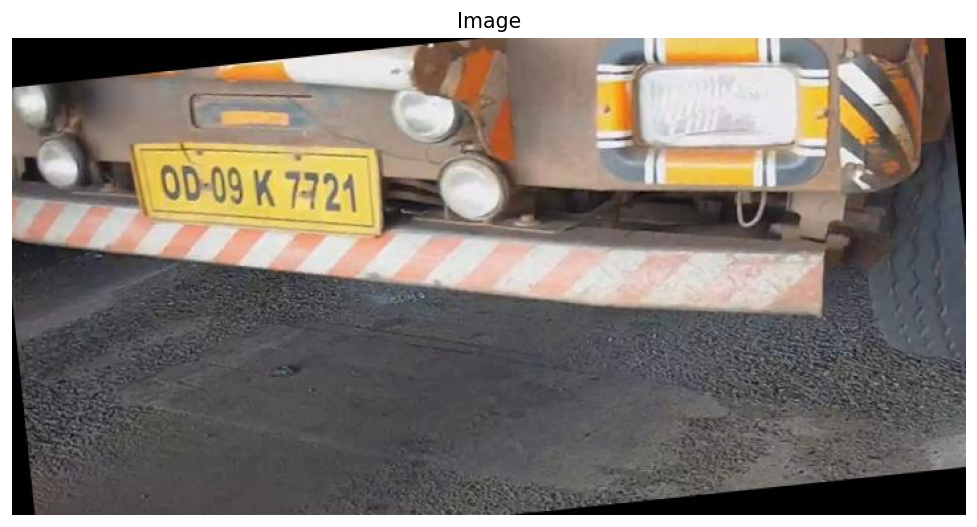

In [23]:
image_path=os.path.join(train_images,os.listdir(train_images)[523])
print(image_path)

image = cv2.imread(image_path)
display_image(image)

# Load a pretrained YOLO model (recommended for training)

In [41]:
# Load a pretrained YOLO model (recommended for training)
model = YOLO("yolov8n.pt")

In [42]:
res= model.predict(
    source=image_path,
    conf=0.25)


img= res[0].orig_img
res[0].summary


image 1/1 /kaggle/working/License-Plate-Detection-5/train/images/OD-09K-7721_jpg.rf.9e9e38bae559eddebfab76ae5e5f61e1.jpg: 320x640 (no detections), 24.2ms
Speed: 1.6ms preprocess, 24.2ms inference, 0.6ms postprocess per image at shape (1, 3, 320, 640)


<bound method Results.summary of ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: None
names: {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair',

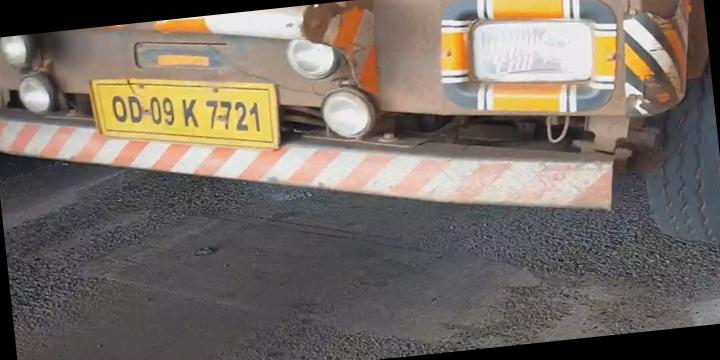

In [43]:
r = res[0]
im_array = r.plot()  # plot a BGR numpy array of predictions
im = Image.fromarray(im_array[..., ::-1])  # RGB PIL image
display(im)

# Train YOLOv8 on a custom dataset

In [44]:
# Path to your data.yaml file
data_yaml_path = os.path.join(dataset.location,working_dir[2])
data_yaml_path

'/kaggle/working/License-Plate-Detection-5/data.yaml'

In [46]:
import yaml

# Load the data.yaml file
with open(data_yaml_path, 'r') as file:
    data = yaml.safe_load(file)

# Modify the paths as needed
data['train'] = '/kaggle/working/License-Plate-Detection-5/train/images'
data['val'] = '/kaggle/working/License-Plate-Detection-5/valid/images'

# Modify the number of classes and their names
data['nc'] = 1  # Number of classes
data['names'] = ['license_plate']  # List of class names

# Save the modified data.yaml file
with open(data_yaml_path, 'w') as file:
    yaml.dump(data, file)

In [47]:
results = model.train(
    data=data_yaml_path, 
    epochs=23, 
    project='Licence_plate',  # Project directory
    name='best_model'  # Subdirectory within the project directory
)

Ultralytics YOLOv8.2.75 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/kaggle/working/License-Plate-Detection-5/data.yaml, epochs=23, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=Licence_plate, name=best_model2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=

wandb: Currently logged in as: pawan-gunjan-gfg (pawankrgunjan). Use `wandb login --relogin` to force relogin


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/License-Plate-Detection-5/train/labels.cache... 2097 images, 83 backgrounds, 0 corrupt: 100%|██████████| 2097/2097 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
val: Scanning /kaggle/working/License-Plate-Detection-5/valid/labels.cache... 200 images, 4 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:00<?, ?it/s]


Plotting labels to Licence_plate/best_model2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to Licence_plate/best_model2
Starting training for 23 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/23      2.49G       1.57      2.257      1.378          2        640: 100%|██████████| 132/132 [00:25<00:00,  5.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.33it/s]


                   all        200        196      0.974       0.96      0.989       0.68

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/23      2.39G      1.107      1.093      1.042          4        640: 100%|██████████| 132/132 [00:23<00:00,  5.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.10it/s]


                   all        200        196      0.958      0.974      0.987       0.76

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/23      2.39G      1.005     0.8363      1.003          0        640: 100%|██████████| 132/132 [00:23<00:00,  5.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.62it/s]

                   all        200        196      0.988      0.995      0.993       0.83



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/23      2.39G     0.9669     0.6868     0.9874          3        640: 100%|██████████| 132/132 [00:23<00:00,  5.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.71it/s]

                   all        200        196      0.967       0.99      0.988      0.786



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/23      2.39G     0.8965     0.6155     0.9658          4        640: 100%|██████████| 132/132 [00:23<00:00,  5.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.63it/s]

                   all        200        196       0.97       0.99      0.989      0.864



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/23      2.39G     0.8542     0.5781       0.95          2        640: 100%|██████████| 132/132 [00:23<00:00,  5.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.32it/s]

                   all        200        196      0.986      0.995      0.994      0.877



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/23      2.39G     0.8032     0.5304     0.9362          4        640: 100%|██████████| 132/132 [00:23<00:00,  5.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.52it/s]

                   all        200        196      0.975      0.995      0.993      0.879



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/23      2.39G     0.7849     0.5102     0.9245          1        640: 100%|██████████| 132/132 [00:23<00:00,  5.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.73it/s]

                   all        200        196      0.983          1      0.994      0.887



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/23      2.39G     0.7525     0.4899     0.9167          1        640: 100%|██████████| 132/132 [00:23<00:00,  5.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.59it/s]

                   all        200        196      0.975          1      0.993      0.891



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/23      2.39G     0.7166     0.4646     0.9063          2        640: 100%|██████████| 132/132 [00:23<00:00,  5.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.99it/s]

                   all        200        196      0.985          1      0.993      0.889



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/23      2.39G     0.7163     0.4653      0.907          3        640: 100%|██████████| 132/132 [00:23<00:00,  5.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.64it/s]

                   all        200        196      0.965          1      0.989      0.897



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/23      2.39G     0.6997     0.4406     0.9003          1        640: 100%|██████████| 132/132 [00:23<00:00,  5.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.53it/s]

                   all        200        196       0.99      0.982      0.994      0.895



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/23      2.39G     0.6757     0.4415     0.8981          4        640: 100%|██████████| 132/132 [00:23<00:00,  5.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.36it/s]

                   all        200        196      0.985       0.99      0.994      0.898


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/23      2.39G      0.571     0.3709     0.8568          1        640: 100%|██████████| 132/132 [00:24<00:00,  5.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.06it/s]

                   all        200        196       0.98          1      0.993      0.875



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/23      2.39G     0.5548     0.3564     0.8537          1        640: 100%|██████████| 132/132 [00:23<00:00,  5.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.39it/s]

                   all        200        196      0.995      0.992      0.995      0.923



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/23      2.39G     0.5366     0.3506     0.8496          1        640: 100%|██████████| 132/132 [00:23<00:00,  5.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.65it/s]

                   all        200        196      0.988      0.985      0.994      0.926



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/23      2.39G     0.5174     0.3429     0.8441          1        640: 100%|██████████| 132/132 [00:23<00:00,  5.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.60it/s]

                   all        200        196      0.978          1      0.989      0.925



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/23      2.39G     0.4989     0.3224      0.839          1        640: 100%|██████████| 132/132 [00:23<00:00,  5.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.27it/s]

                   all        200        196      0.979          1      0.994      0.933



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/23      2.39G     0.4785     0.3089     0.8279          1        640: 100%|██████████| 132/132 [00:23<00:00,  5.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.08it/s]

                   all        200        196      0.984      0.995      0.994      0.939



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/23      2.39G     0.4623     0.3039     0.8236          1        640: 100%|██████████| 132/132 [00:23<00:00,  5.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.18it/s]

                   all        200        196      0.985      0.995      0.994      0.929



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/23      2.39G     0.4455     0.2908     0.8213          1        640: 100%|██████████| 132/132 [00:23<00:00,  5.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.01it/s]

                   all        200        196      0.984       0.99      0.994      0.945



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/23      2.39G     0.4326     0.2872     0.8215          1        640: 100%|██████████| 132/132 [00:23<00:00,  5.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.88it/s]

                   all        200        196       0.98      0.994      0.994      0.943



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/23      2.39G     0.4183     0.2702     0.8144          1        640: 100%|██████████| 132/132 [00:23<00:00,  5.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.09it/s]

                   all        200        196      0.985      0.989      0.994       0.95



23 epochs completed in 0.175 hours.
Optimizer stripped from Licence_plate/best_model2/weights/last.pt, 6.2MB
Optimizer stripped from Licence_plate/best_model2/weights/best.pt, 6.2MB

Validating Licence_plate/best_model2/weights/best.pt...
Ultralytics YOLOv8.2.75 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.92it/s]


                   all        200        196      0.985      0.989      0.994      0.951
Speed: 0.1ms preprocess, 2.1ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to Licence_plate/best_model2


lr/pg0,▃▆██▇▇▇▆▆▆▅▅▅▄▄▃▃▃▂▂▂▁▁
lr/pg1,▃▆██▇▇▇▆▆▆▅▅▅▄▄▃▃▃▂▂▂▁▁
lr/pg2,▃▆██▇▇▇▆▆▆▅▅▅▄▄▃▃▃▂▂▂▁▁
metrics/mAP50(B),▃▁▇▂▃█▇▇▆▇▃██▆█▇▃▇█▇█▇█
metrics/mAP50-95(B),▁▃▅▄▆▆▆▆▆▆▇▇▇▆▇▇▇██▇███
metrics/precision(B),▄▁▇▃▃▆▄▆▄▆▂▇▆▅█▇▅▅▆▆▆▅▆
metrics/recall(B),▁▄▇▆▆▇▇████▅▆█▇▅██▇▇▆▇▆
model/GFLOPs,▁
model/parameters,▁
model/speed_PyTorch(ms),▁
train/box_loss,█▅▅▄▄▄▃▃▃▃▃▃▃▂▂▂▂▁▁▁▁▁▁


# Load the trained model

In [48]:
import shutil

# Define source and destination paths
source_dir = 'Licence_plate/best_model'
destination_dir = '/kaggle/working/Licence_plate'

os.makedirs(destination_dir, exist_ok=True)

files = os.listdir(source_dir)
# Move each file
for file_name in files:
    src_file = os.path.join(source_dir, file_name)
    dst_file = os.path.join(destination_dir, file_name)
    
    # Check if it's a file or directory and move accordingly
    if os.path.isfile(src_file):
        shutil.move(src_file, dst_file)
    elif os.path.isdir(src_file):
        shutil.move(src_file, dst_file)

In [49]:
from ultralytics import YOLO

trained_model = YOLO('/kaggle/working/Licence_plate/weights/best.pt')

# Predictions

In [50]:
test_dir = '/kaggle/working/License-Plate-Detection-5/test'
test_images=os.path.join(test_dir,'images')
img_path = os.path.join(test_images, os.listdir(test_images)[0])
results = trained_model(img_path)

print(results)


image 1/1 /kaggle/working/License-Plate-Detection-5/test/images/OD-05AY-2540_jpg.rf.a4e282f47c6c024b37d418f98844e4d3.jpg: 320x640 1 license_plate, 10.1ms
Speed: 1.5ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 320, 640)
[ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: None
names: {0: 'license_plate'}
obb: None
orig_img: array([[[221, 215, 220],
        [223, 217, 222],
        [223, 219, 224],
        ...,
        [235, 230, 239],
        [235, 230, 239],
        [235, 230, 239]],

       [[219, 218, 220],
        [219, 218, 220],
        [218, 217, 219],
        ...,
        [235, 231, 237],
        [235, 230, 239],
        [235, 231, 237]],

       [[213, 220, 217],
        [214, 221, 218],
        [214, 221, 218],
        ...,
        [235, 231, 236],
        [235, 231, 237],
        [235, 231, 236]],

       ...,

       [[ 81,  93, 105],
        [ 83,  95, 107],
      

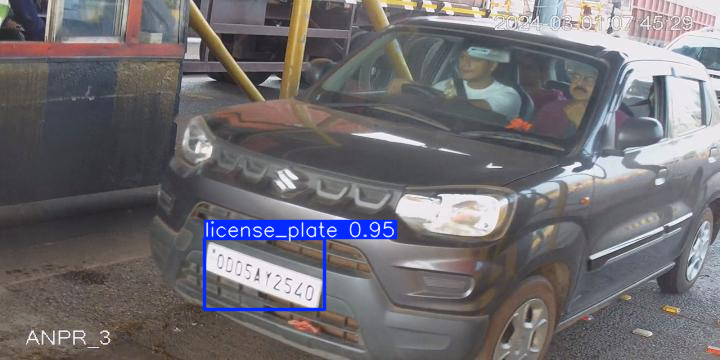

In [51]:
r = results[0]
im_array = r.plot()  # plot a BGR numpy array of predictions
im = Image.fromarray(im_array[..., ::-1])  # RGB PIL image
display(im)

# Validate the model

In [52]:
# Define directories
test_images_dir = '/kaggle/working/License-Plate-Detection-5/test/images'
test_labels_dir = '/kaggle/working/License-Plate-Detection-5/test/labels'

In [53]:
def load_labels(label_path):
    labels = []
    with open(label_path, 'r') as file:
        for line in file:
            parts = line.strip().split()
            if len(parts) >= 5:
                # Class ID, x_center, y_center, width, height
                labels.append([int(parts[0]), float(parts[1]), float(parts[2]), float(parts[3]), float(parts[4])])
    return labels

In [54]:
def evaluate_image(image_file):
    img_path = os.path.join(test_images_dir, image_file)
    label_file = image_file.replace('.jpg', '.txt').replace('.png', '.txt')
    label_path = os.path.join(test_labels_dir, label_file)

    # Get model predictions
    results = trained_model(img_path)  # List of results
    if len(results) > 0:
        result = results[0]  # Get the first result
        boxes = result.boxes  # Get bounding boxes
        predictions = []
        if boxes is not None:
            for box in boxes.xyxy:
                # Ensure each box is not None
                if box is not None:
                    xmin, ymin, xmax, ymax = box[:4]
                    conf = box[4] if len(box) > 4 and box[4] is not None else None
                    class_id = int(box[5]) if len(box) > 5 and box[5] is not None else None
                    predictions.append([xmin.item() if xmin is not None else None,
                                        ymin.item() if ymin is not None else None,
                                        xmax.item() if xmax is not None else None,
                                        ymax.item() if ymax is not None else None,
                                        conf.item() if conf is not None else None,
                                        class_id])
            predictions_df = pd.DataFrame(predictions, columns=['xmin', 'ymin', 'xmax', 'ymax', 'confidence', 'class'])
        else:
            predictions_df = pd.DataFrame(columns=['xmin', 'ymin', 'xmax', 'ymax', 'confidence', 'class'])
    else:
        predictions_df = pd.DataFrame(columns=['xmin', 'ymin', 'xmax', 'ymax', 'confidence', 'class'])

    # Load ground truth labels
    if os.path.exists(label_path):
        ground_truth = load_labels(label_path)
    else:
        ground_truth = []

    # Print results
    print(f"Results for {image_file}:")
    print(f"Predictions:\n{predictions_df}")
    print(f"Ground Truth:\n{ground_truth}")

In [55]:
# Evaluate all images
image_files = [f for f in os.listdir(test_images_dir) if f.endswith(('.jpg', '.png'))]

for image_file in image_files:
    evaluate_image(image_file)


image 1/1 /kaggle/working/License-Plate-Detection-5/test/images/OD-05AY-2540_jpg.rf.a4e282f47c6c024b37d418f98844e4d3.jpg: 320x640 1 license_plate, 8.5ms
Speed: 2.2ms preprocess, 8.5ms inference, 1.3ms postprocess per image at shape (1, 3, 320, 640)
Results for OD-05AY-2540_jpg.rf.a4e282f47c6c024b37d418f98844e4d3.jpg:
Predictions:
         xmin        ymin        xmax        ymax confidence class
0  204.384125  238.984329  324.401459  309.986206       None  None
Ground Truth:
[[0, 0.36527777777777776, 0.7666666666666667, 0.1673611111111111, 0.19722222222222222]]

image 1/1 /kaggle/working/License-Plate-Detection-5/test/images/OD-02AH-7766_jpg.rf.3aa4bdc67592711c46a29d712cfe7bb1.jpg: 320x640 1 license_plate, 6.8ms
Speed: 1.3ms preprocess, 6.8ms inference, 1.2ms postprocess per image at shape (1, 3, 320, 640)
Results for OD-02AH-7766_jpg.rf.3aa4bdc67592711c46a29d712cfe7bb1.jpg:
Predictions:
         xmin        ymin       xmax        ymax confidence class
0  347.920593  209.677948  431.0